In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
from scipy.stats import linregress

import rasterio
from rasterio.windows import Window
from rasterio.transform import Affine
from rasterio.mask import mask

from joblib import Parallel, delayed 

# import rioxarray as rxr
# import xarray as xr
# import dask.array as da
# from dask.diagnostics import ProgressBar


In [5]:
# define filepaths, objects

home = '/global/scratch/users/erin_carroll/'
tif_folder = home+'/data/tifs/GMUG_/'
years = range(2018,2025)
months = ['jul','aug','sep']
indices = ['NDMI', 'NDVI']

In [ ]:
########################
## TREND POLYGONS
########################

In [33]:
# load spatial data

gmug = gpd.read_file(home+'data/spatial_data/gmug/').to_crs(32613)
# fsveg = gpd.read_file(home+'SUFHER/shp/FSVegSpatial2Feb2021/FSVegSpatial2Feb2021.shp').to_crs(32613)
fsveg = gpd.read_file(home+'SUFHER/shp/FSVegSpatial2Feb2021.gpkg').to_crs(32613)
print(fsveg.crs, gmug.crs)

epsg:32613 epsg:32613


In [38]:
# filter fsveg to intersects GMUG
print(len(fsveg))
fsveg = gpd.sjoin(fsveg, gmug, op='intersects')
len(fsveg)

66010


64111

In [35]:
size_bytes = fsveg.memory_usage(deep=True).sum()
print(f"Approximate memory usage: {size_bytes / 1e6:.2f} MB")

Approximate memory usage: 345.70 MB


In [36]:
# filter fsveg to useful columns
fsveg = fsveg[['ACRES', 'COVER_TYPE', 'STAND_ID', 'geometry']].reset_index()

In [37]:
size_bytes = fsveg.memory_usage(deep=True).sum()
print(f"Approximate memory usage: {size_bytes / 1e6:.2f} MB")

Approximate memory usage: 10.30 MB


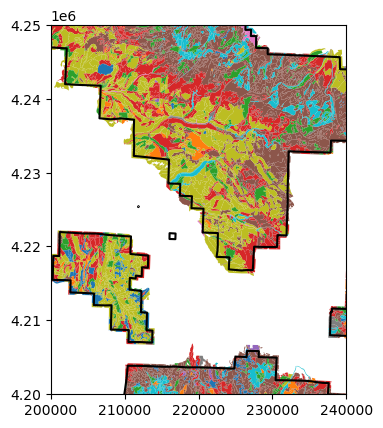

In [39]:
# visualize
fig, ax = plt.subplots()
fsveg.plot(ax=ax, column='COVER_TYPE')
gmug.boundary.plot(ax=ax, color='black')

ax.set_xlim([200000, 240000])
ax.set_ylim([4200000, 4250000])

plt.show()

In [40]:
# STAND_ID is almost but not fully unique?? Need to assign a unique id
print(len(fsveg) - len(fsveg.STAND_ID.unique()))
fsveg['unique_id'] = range(0, len(fsveg))

5805


In [48]:
def raster_data_to_polygon(raster_fp, shp):
    name = raster_fp.split('/')[-1].strip('.tif')
    y = name.split('_')[0]
    m = name.split('_')[1][1:]
    idx = name.split('_')[2]
    
    stats_list = []
    with rasterio.open(raster_fp) as src:
        shp_ = shp.copy()
        # iterate over each polygon feature in the shapefile
        for index, row in shp_.iterrows():
            geometry = [row.geometry]
            
            try:
                masked_raster, _ = mask(src, geometry, crop=True, filled=True, nodata=np.nan) # Mask the raster with the polygon         
                data = masked_raster[0].flatten() # Convert masked raster to a 1D array and remove NaNs
                data = data[~np.isnan(data)]  # Remove nodata values
                if len(data) > 0:
                    min_val = np.min(data)
                    mean_val = np.mean(data)
                    max_val = np.max(data)
                    std_val = np.std(data)
                else:
                    min_val, mean_val, max_val, std_val = np.nan, np.nan, np.nan, np.nan  # Handle empty geometries
    
            except:
                min_val, mean_val, max_val, std_val = np.nan, np.nan, np.nan, np.nan  # Handle errors gracefully
    
            # Store statistics
            stats_list.append((min_val, mean_val, max_val, std_val, y, m, idx))

            
    # Convert statistics list into separate columns
    shp_[['min', 'mean', 'max', 'std', 'year', 'month', 'idx']] = stats_list
    return shp_

In [49]:
fps = sorted(glob(tif_folder+f'/*/*/*.tif'))
args = list(product(fps, [fsveg]))

dfs = Parallel(n_jobs=20)(
    delayed(raster_data_to_polygon)(raster_fp, shp) for raster_fp, shp in args
)
# started 2:45 (done 6 mins later!)

In [50]:
fsveg_ = pd.concat(dfs, ignore_index=True)
fsveg_['name'] = fsveg_['idx']+'_'+fsveg_['year']+'_'+fsveg_['month']+'_mean'
fsveg_

,index,ACRES,COVER_TYPE,STAND_ID,geometry,index_right,ADMINFORES,REGION,FORESTNUMB,FORESTORGC,...,SHAPE_LEN,unique_id,min,mean,max,std,year,month,idx,name
0,0,32.25,TSF,020508550202027,"MULTIPOLYGON (((274391.174 4332930.027, 274355...",0,99020400010343,02,04,0204,...,24.5211,0,0.025536,0.131797,0.271962,0.044391,2017,jul,NDMI,NDMI_2017_jul_mean
1,1,74.97,TAA,020507BE0102064,"MULTIPOLYGON (((333586.027 4236428.430, 333488...",0,99020400010343,02,04,0204,...,24.5211,1,-0.01784,0.228635,0.346643,0.067949,2017,jul,NDMI,NDMI_2017_jul_mean
2,2,19.37,TAA,022402130702113,"MULTIPOLYGON (((247168.243 4323317.932, 247148...",0,99020400010343,02,04,0204,...,24.5211,2,0.038693,0.202653,0.34815,0.048485,2017,jul,NDMI,NDMI_2017_jul_mean
3,3,29.44,TAA,020508530500592,"MULTIPOLYGON (((291081.775 4270439.309, 291040...",0,99020400010343,02,04,0204,...,24.5211,3,0.110472,0.282901,0.385819,0.039428,2017,jul,NDMI,NDMI_2017_jul_mean
4,4,39.30,TSF,020507990900112,"MULTIPOLYGON (((329293.499 4314347.808, 329269...",0,99020400010343,02,04,0204,...,24.5211,4,-0.199894,0.106864,0.254933,0.063328,2017,jul,NDMI,NDMI_2017_jul_mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077323,66004,292.16,NBA,020406790107018,"MULTIPOLYGON (((234101.641 4327203.226, 234089...",0,99020400010343,02,04,0204,...,24.5211,64106,0.127786,0.359783,0.578457,0.05302,2024,sep,NDVI,NDVI_2024_sep_mean
3077324,66005,292.16,NBA,020406790107018,"MULTIPOLYGON (((323804.162 4311369.581, 323802...",0,99020400010343,02,04,0204,...,24.5211,64107,0.212739,0.344658,0.533737,0.054093,2024,sep,NDVI,NDVI_2024_sep_mean
3077325,66006,292.16,NBA,020406790107018,"MULTIPOLYGON (((385935.283 4249324.664, 385929...",0,99020400010343,02,04,0204,...,24.5211,64108,0.19223,0.395698,0.58214,0.08977,2024,sep,NDVI,NDVI_2024_sep_mean
3077326,66008,292.16,NBA,020406790107018,"MULTIPOLYGON (((331383.959 4238061.126, 331368...",0,99020400010343,02,04,0204,...,24.5211,64109,0.07939,0.13858,0.458154,0.066511,2024,sep,NDVI,NDVI_2024_sep_mean


In [21]:
##########################
## Run models on polygons
##########################

In [51]:
# create decimal_year time variable
month_map = {'jul': 7, 'aug': 8, 'sep': 9}
fsveg_['month_num'] = fsveg_['month'].map(month_map)
fsveg_['year'] = fsveg_['year'].astype(int)
fsveg_['mean'] = fsveg_['mean'].astype(float)


fsveg_['decimal_time'] = fsveg_['year'] + (fsveg_['month_num'] - 1) / 12

In [52]:
fsveg_['decimal_time'].unique()

array([2017.5       , 2017.58333333, 2017.66666667, 2018.5       ,
       2018.58333333, 2018.66666667, 2019.5       , 2019.58333333,
       2019.66666667, 2020.5       , 2020.58333333, 2020.66666667,
       2021.5       , 2021.58333333, 2021.66666667, 2022.5       ,
       2022.58333333, 2022.66666667, 2023.5       , 2023.58333333,
       2023.66666667, 2024.5       , 2024.58333333, 2024.66666667])

In [54]:
# remove 2017
fsveg_ = fsveg_[fsveg_['year']!=2017]
len(fsveg_)

2692662

In [55]:
# define a function to fit a linear model and return slope and p-value
def fit_slope(group):
    if len(group) < 2 or group['mean'].isnull().all():
        return pd.Series({'slope': float('nan'), 'p_value': float('nan')})
    result = linregress(group['decimal_time'], group['mean'])
    return pd.Series({'slope': result.slope, 'p_value': result.pvalue})

In [56]:
# deploy per unique polygon
fsveg_model = fsveg_.groupby(['unique_id', 'ACRES', 'COVER_TYPE', 'STAND_ID', 'idx']).apply(fit_slope).reset_index()

In [57]:
fsveg_model

,unique_id,ACRES,COVER_TYPE,STAND_ID,idx,slope,p_value
0,0,32.25,TSF,020508550202027,NDMI,0.004501,0.092385
1,0,32.25,TSF,020508550202027,NDVI,0.006060,0.052758
2,1,74.97,TAA,020507BE0102064,NDMI,0.000127,0.980449
3,1,74.97,TAA,020507BE0102064,NDVI,-0.000779,0.935680
4,2,19.37,TAA,022402130702113,NDMI,-0.003104,0.403838
...,...,...,...,...,...,...,...
128217,64108,292.16,NBA,020406790107018,NDVI,-0.001215,0.798461
128218,64109,292.16,NBA,020406790107018,NDMI,0.006648,0.047838
128219,64109,292.16,NBA,020406790107018,NDVI,0.002304,0.166619
128220,64110,292.16,NBA,020406790107018,NDMI,-0.004818,0.015759


(array([35860., 17646., 14061., 11746., 10241.,  8733.,  8021.,  7595.,
         6985.,  6926.]),
 array([3.67794602e-12, 9.99977447e-02, 1.99995489e-01, 2.99993234e-01,
        3.99990979e-01, 4.99988723e-01, 5.99986468e-01, 6.99984213e-01,
        7.99981958e-01, 8.99979702e-01, 9.99977447e-01]),
 <BarContainer object of 10 artists>)

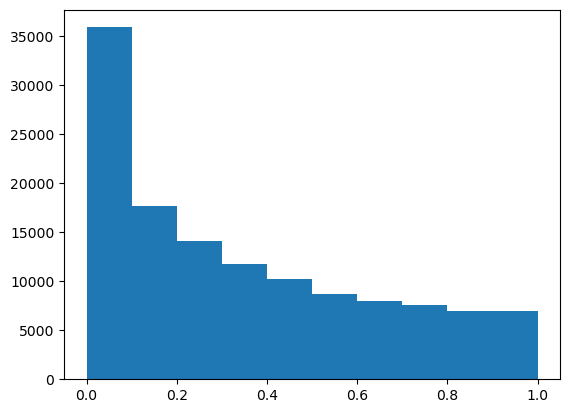

In [58]:
plt.hist(fsveg_model.p_value)

In [59]:
# cnvert back to wide
fsveg_model_wide = fsveg_model.pivot_table(index=['unique_id', 'ACRES', 'COVER_TYPE', 'STAND_ID'],
                   columns='idx',
                   values=['slope', 'p_value']).reset_index()
fsveg_model_wide.columns = ['_'.join([str(i) for i in col if i]) if isinstance(col, tuple) else col
                            for col in fsveg_model_wide.columns]

In [60]:
fsveg_model_wide

,unique_id,ACRES,COVER_TYPE,STAND_ID,p_value_NDMI,p_value_NDVI,slope_NDMI,slope_NDVI
0,0,32.25,TSF,020508550202027,9.238530e-02,0.052758,0.004501,0.006060
1,1,74.97,TAA,020507BE0102064,9.804485e-01,0.935680,0.000127,-0.000779
2,2,19.37,TAA,022402130702113,4.038384e-01,0.586055,-0.003104,-0.002297
3,3,29.44,TAA,020508530500592,4.725107e-01,0.510729,0.008277,0.007225
4,4,39.30,TSF,020507990900112,9.655862e-08,0.001370,-0.011468,-0.009140
...,...,...,...,...,...,...,...,...
63902,64106,292.16,NBA,020406790107018,4.960205e-02,0.756276,0.002702,0.000455
63903,64107,292.16,NBA,020406790107018,9.316407e-01,0.689871,-0.000194,-0.001026
63904,64108,292.16,NBA,020406790107018,4.973679e-01,0.798461,0.002722,-0.001215
63905,64109,292.16,NBA,020406790107018,4.783785e-02,0.166619,0.006648,0.002304


In [ ]:
# reattch to geometry

In [61]:
id_cols = ['unique_id']
geom = fsveg_.drop_duplicates(subset=id_cols)[id_cols+['geometry']]

In [62]:
fsveg_model_geom = fsveg_model_wide.merge(geom[['unique_id', 'geometry']], on='unique_id', how='left')
fsveg_model_geom = gpd.GeoDataFrame(fsveg_model_geom, geometry='geometry', crs=geom.crs)

In [ ]:
# export

In [63]:
fp_out = home+'SUFHER/shp/fsveg_gmug.gpkg'
fsveg_model_geom.to_file(fp_out, driver="GPKG")

In [64]:
fsveg_model_geom = fsveg_model_geom.rename(columns={
    'p_value_NDMI': 'p_NDMI',
    'p_value_NDVI': 'p_NDVI'
})

In [65]:
fp_out = home+'SUFHER/shp/fsveg_gmug/fsveg_gmug.shp'
fsveg_model_geom.to_file(fp_out)

In [ ]:
########################
## TREND RASTER
########################

# abandoned for now... come back later if time

In [3]:
# # this does work, but it takes like 5 mins per tif to load
# block_size = 1024

# with rasterio.open(fps[0]) as src:
#     out_meta = src.meta.copy()
    
# out_meta.update({
#     "compress": "lzw",
#     "tiled": True,
#     "blockxsize": block_size,
#     "blockysize": block_size
# })
# out_meta

In [4]:
# def compute_slope_block(stack, time):
#     """Compute slope per pixel using linear regression (vectorized)"""
#     T, H, W = stack.shape
#     mask = ~np.isnan(stack)
#     n = mask.sum(axis=0)
#     x = time.reshape(-1, 1)

#     # Replace NaNs with 0 just for sums
#     stack_filled = np.nan_to_num(stack, nan=0.0)
#     sum_y = stack_filled.sum(axis=0)
#     sum_xy = (x * stack_filled).sum(axis=0)
#     sum_x = np.sum(time)
#     sum_x2 = np.sum(time**2)

#     numerator = n * sum_xy - sum_x * sum_y
#     denominator = n * sum_x2 - sum_x**2

#     with np.errstate(divide='ignore', invalid='ignore'):
#         slope = numerator / denominator
#         slope[n < 2] = np.nan  # if <2 points, set to NaN

#     return slope.astype(np.float32)

# arrays = [rxr.open_rasterio(p, chunks={'x': 1024, 'y': 1024}).squeeze() for p in fps] # srated 2:42 pm
# stacked = xr.concat(arrays, dim='time')  # shape: (time, y, x)